In [22]:
# Import libraries
import requests
from bs4 import BeautifulSoup
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


By looking at the GET requests sent by the browser when loading the world rankings page (using Postman), we have found the file that contains the data we need. We first send a GET request to receive it, and then turn it into a DataFrame and select only the columns that we need.

In [2]:
r = requests.get('https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json')
table_body = r.json()
df = pd.DataFrame(table_body['data'])
ranking_complete=df[['rank', 'name', 'location', 'url', 'scores_overall', 'scores_teaching', 'scores_research', 
   'scores_citations', 'scores_industry_income', 'scores_international_outlook', 'stats_number_students',
   'stats_student_staff_ratio', 'stats_pc_intl_students']]

In [3]:
ranking_complete

,rank,name,location,url,scores_overall,scores_teaching,scores_research,scores_citations,scores_industry_income,scores_international_outlook,stats_number_students,stats_student_staff_ratio,stats_pc_intl_students
0,1,University of Oxford,United Kingdom,/world-university-rankings/university-oxford,94.3,86.7,99.5,99.1,63.7,95.0,"20,409",11.2,38%
1,2,University of Cambridge,United Kingdom,/world-university-rankings/university-cambridge,93.2,87.8,97.8,97.5,51.5,93.0,"18,389",10.9,35%
2,=3,California Institute of Technology,United States,/world-university-rankings/california-institut...,93.0,90.3,97.5,99.5,92.6,59.7,"2,209",6.5,27%
3,=3,Stanford University,United States,/world-university-rankings/stanford-university,93.0,89.1,96.7,99.9,60.5,77.6,"15,845",7.5,22%
4,5,Massachusetts Institute of Technology,United States,/world-university-rankings/massachusetts-insti...,92.5,87.3,91.9,100.0,88.4,87.6,"11,177",8.7,34%
5,6,Harvard University,United States,/world-university-rankings/harvard-university,91.8,84.2,98.4,99.7,46.4,79.7,"20,326",8.9,26%
6,7,Princeton University,United States,/world-university-rankings/princeton-university,91.1,85.7,93.9,99.6,58.0,78.7,"7,955",8.3,24%
7,8,Imperial College London,United Kingdom,/world-university-rankings/imperial-college-lo...,89.2,81.7,88.7,96.7,71.6,96.6,"15,857",11.4,55%
8,9,University of Chicago,United States,/world-university-rankings/university-chicago,88.6,85.3,90.1,99.4,39.8,69.6,"13,525",6.2,25%
9,=10,ETH Zurich – Swiss Federal Institute of Techno...,Switzerland,/world-university-rankings/eth-zurich-swiss-fe...,87.7,76.4,92.0,94.3,60.3,98.1,"19,233",14.6,38%


All columns are of type 'object' right now, which is not what we want. In addition, some columns have certain characteristics:
* The stats_pc_intl_students column which is the percentage of international students, has a % sign.
* Values in stats_number_students have commas.
* In all of the score columns, in some rows we have values of the form a-b where a and b are numbers. We will take their average as the actual score.
* The rank column includes three types of irregularity: =i indicates a tie at rank i (we will remove the =), i-j indicates a rank range (we will take the average as the rank), and i+ indicates a rank above i (again we will simply remove the +). 

In [4]:
ranking_complete.loc[:,'stats_pc_intl_students'] = ranking_complete['stats_pc_intl_students'].apply(lambda x: float(x.strip('%'))/100.0)
ranking_complete.loc[:,'stats_number_students'] = ranking_complete.loc[:,'stats_number_students'].replace(',','',regex=True).values
ranking_complete.loc[:,'stats_number_students':'stats_student_staff_ratio'] = ranking_complete.loc[:,'stats_number_students':'stats_student_staff_ratio'].astype('float64')

C:\Users\asus\Anaconda3\lib\site-packages\pandas\core\indexing.py:601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
C:\Users\asus\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [5]:
dash_character = '–'
def fix_float_value(value):
    if (str(value).find(dash_character) == -1):
        return float(value)
    parts = str(value).split(dash_character)
    return (float(parts[0])+float(parts[1]))/2.0

def fix_int_value(value):
    value = str(value)
    if (value.find(dash_character) == -1):
        if (value.find('=') == -1):
            if (value.find('+') == -1):
                return int(value)
            else:
                return int(value.strip('+'))
        else:
            return int(value.strip('='))
    else:
        parts = value.split(dash_character)
        return int((int(parts[0])+float(parts[1]))/2.0)
    
score_columns = ['scores_overall', 'scores_teaching', 'scores_research', 
   'scores_citations', 'scores_industry_income', 'scores_international_outlook']
for col in score_columns:
    ranking_complete[col] = ranking_complete[col].apply(fix_float_value)

ranking_complete['rank'] = ranking_complete['rank'].apply(fix_int_value)

C:\Users\asus\Anaconda3\lib\site-packages\ipykernel\__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\asus\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


To add the region (which is missing from our data), we use the data contained in the __other__ dataset.

In [6]:
topunis_data = pickle.load(open('topuniversities.p','rb'))
ranking_w_region = pd.merge(ranking_complete, topunis_data[['country', 'region']].drop_duplicates(), left_on='location', right_on='country').drop('country', axis=1)
ranking_w_region = ranking_w_region.sort_values(ascending=[True], by=['rank'])

In [7]:
ranking_w_region.head()

,rank,name,location,url,scores_overall,scores_teaching,scores_research,scores_citations,scores_industry_income,scores_international_outlook,stats_number_students,stats_student_staff_ratio,stats_pc_intl_students,region
0,1,University of Oxford,United Kingdom,/world-university-rankings/university-oxford,94.3,86.7,99.5,99.1,63.7,95.0,20409.0,11.2,0.38,Europe
1,2,University of Cambridge,United Kingdom,/world-university-rankings/university-cambridge,93.2,87.8,97.8,97.5,51.5,93.0,18389.0,10.9,0.35,Europe
93,3,California Institute of Technology,United States,/world-university-rankings/california-institut...,93.0,90.3,97.5,99.5,92.6,59.7,2209.0,6.5,0.27,North America
94,3,Stanford University,United States,/world-university-rankings/stanford-university,93.0,89.1,96.7,99.9,60.5,77.6,15845.0,7.5,0.22,North America
95,5,Massachusetts Institute of Technology,United States,/world-university-rankings/massachusetts-insti...,92.5,87.3,91.9,100.0,88.4,87.6,11177.0,8.7,0.34,North America


In [8]:
ranking_w_region.dtypes

rank                              int64
name                             object
location                         object
url                              object
scores_overall                  float64
scores_teaching                 float64
scores_research                 float64
scores_citations                float64
scores_industry_income          float64
scores_international_outlook    float64
stats_number_students           float64
stats_student_staff_ratio       float64
stats_pc_intl_students          float64
region                           object
dtype: object

Now we will calculate the best countries in terms of student to staff ratio (highest considered best) and also in terms of percentage of international students (highest considered best):

In [9]:
ranking_w_region.sort_values(ascending=[False], by=['stats_pc_intl_students'])[['name','rank','stats_pc_intl_students']].head(20)

,name,rank,stats_pc_intl_students
855,American University of Sharjah,700,0.84
4,London School of Economics and Political Science,25,0.71
633,Royal College of Surgeons in Ireland,225,0.64
856,University of Sharjah,900,0.61
57,"Soas, University of London",450,0.56
251,École Polytechnique Fédérale de Lausanne,38,0.55
2,Imperial College London,8,0.55
49,"City, University of London",375,0.53
551,Maastricht University,103,0.50
3,University College London,16,0.49


In [10]:
ranking_w_region.sort_values(ascending=[False], by=['stats_student_staff_ratio'])[['name','rank','stats_student_staff_ratio']].head(20)

,name,rank,stats_student_staff_ratio
873,Anadolu University,1001,864.6
422,Technical University of Dortmund,325,99.6
728,University of South Africa,900,89.6
395,University of Bonn,100,77.9
410,University of Passau,225,74.8
397,University of Mannheim,125,74.5
416,Bielefeld University,275,66.8
424,Leibniz University of Hanover,375,65.3
393,Technical University of Berlin,92,64.3
412,Ruhr University Bochum,225,61.1


Now we want similar stats aggregated on country/region. We will have to calculate the number of international students and staff for each university, and then we will aggregate by country/region and sum and divide the total number of international students by total number of students for each country/region (and similarly for the student to staff ratio).

First we will display the stats for the aggregation on country:

In [11]:
ranking_extended_1 = ranking_w_region.copy()
ranking_extended_1['num_intl_students'] = ranking_extended_1['stats_pc_intl_students']*ranking_extended_1['stats_number_students']
ranking_extended_1['num_staff'] = ranking_extended_1['stats_number_students']/ranking_extended_1['stats_student_staff_ratio']

As you can see below, UAE has the highest ratio of international students, with more than 50% of students being international.

In [12]:
cols_list = ['name', 'num_staff', 'num_intl_students', 'stats_number_students']

def do_country_region_agg(df, col_name, columns_list):
    columns_list.append(col_name)
    df_agg = df[columns_list]
    df_agg = df_agg.groupby(col_name).sum()
    df_agg['ratio_intl_student'] = df_agg['num_intl_students']/df_agg['stats_number_students']
    df_agg['ratio_student_staff'] = df_agg['stats_number_students']/df_agg['num_staff']
    return df_agg

ranking_aggregated_country = do_country_region_agg(ranking_extended_1, 'location', cols_list)
ranking_aggregated_country.sort_values(ascending=False, by='ratio_intl_student').head(20)

,num_staff,num_intl_students,stats_number_students,ratio_intl_student,ratio_student_staff
location,,,,,
United Arab Emirates,2140.697510,15917.32,29704.0,0.535865,13.875851
Qatar,758.068182,5603.64,13342.0,0.420000,17.600000
Hong Kong,5147.293399,28598.89,89130.0,0.320867,17.315897
Singapore,3364.473475,17085.29,56101.0,0.304545,16.674526
Switzerland,11335.835103,38263.67,130293.0,0.293674,11.493904
United Kingdom,95081.095981,433837.30,1493686.0,0.290447,15.709600
New Zealand,7580.819927,34816.00,126545.0,0.275127,16.692785
Australia,29422.758699,203601.46,783464.0,0.259873,26.627823
Austria,8585.314426,27136.63,112265.0,0.241719,13.076399


And Turkey has the highest total student to staff ratio with a ratio of almost 80 - which is about double the ratio for the second country in the list, Kenya.

In [13]:
ranking_aggregated_country.sort_values(ascending=False, by='ratio_student_staff').head(20)

,num_staff,num_intl_students,stats_number_students,ratio_intl_student,ratio_student_staff
location,,,,,
Turkey,31450.524291,45493.01,2526578.0,0.018006,80.335004
Kenya,1788.879493,0.00,84614.0,0.000000,47.300000
Morocco,5086.078719,5262.64,230265.0,0.022855,45.273582
Germany,30790.339293,153294.92,1145370.0,0.133839,37.199005
South Africa,10184.418565,38039.73,370288.0,0.102730,36.358286
Ghana,1123.532764,788.72,39436.0,0.020000,35.100000
Belgium,5534.182254,34666.95,185911.0,0.186471,33.593220
Sri Lanka,711.090343,0.00,22826.0,0.000000,32.100000
Greece,6065.315962,10801.89,189680.0,0.056948,31.272897


In [25]:
ranking_aggregated_country.describe()

,num_staff,num_intl_students,stats_number_students,ratio_intl_student,ratio_student_staff
count,70.000000,70.000000,7.000000e+01,70.000000,70.000000
mean,20966.874855,37010.518714,3.754241e+05,0.106164,19.407398
std,39692.606619,80924.449597,6.187146e+05,0.106592,11.127758
min,711.090343,0.000000,7.623000e+03,0.000000,6.800000
25%,3658.414475,2299.710000,5.610550e+04,0.024441,13.331802
50%,8083.067176,11912.565000,1.256505e+05,0.078337,16.815217
75%,21345.455741,32467.127500,3.750078e+05,0.138152,19.774660
max,273280.434476,457921.130000,3.566446e+06,0.535865,80.335004


And here are bar charts for the stats we calculated (1st one is intl. student ratio, 2nd one is student/staff ratio):

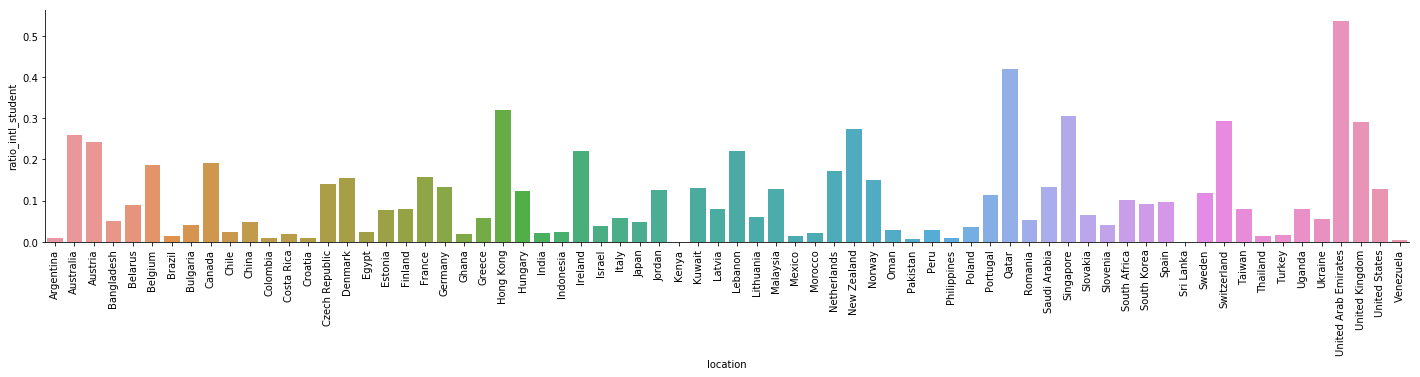

In [53]:
ax = sns.factorplot(kind = 'bar', x="location", y="ratio_intl_student", data=ranking_aggregated_country.reset_index(), aspect=5)
plt.xticks(rotation=90)
plt.show(ax)

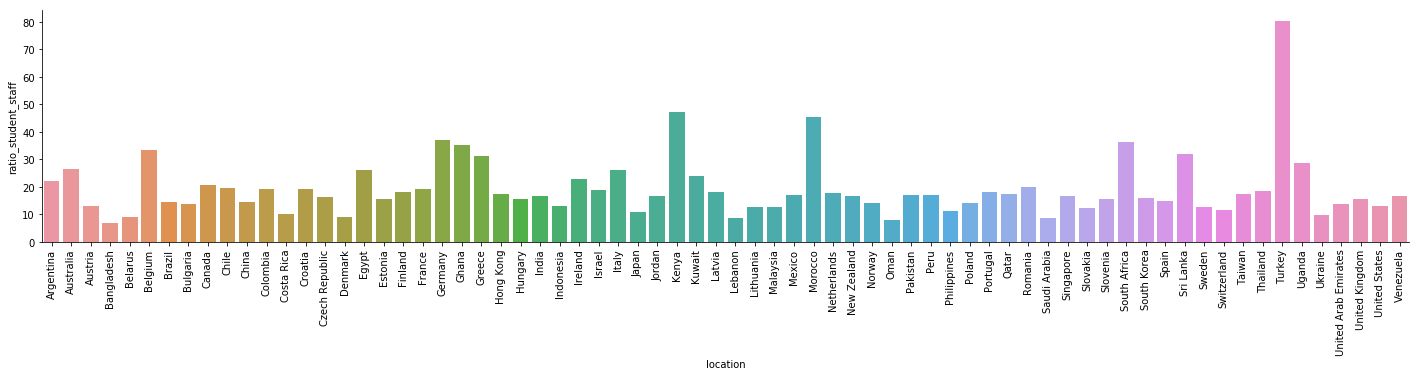

In [54]:
ax = sns.factorplot(kind = 'bar', x="location", y="ratio_student_staff", data=ranking_aggregated_country.reset_index(), aspect=5)
plt.xticks(rotation=90)
plt.show(ax)

And now aggregated by region: first sorted by ratio of international students and then by ratio of students to staff. We can see that Oceania has the highest international student ratio, while Latin America has the lowest ratio with only 1.5%. Also, Africa has the most students per staff while North America has the fewest.

In [14]:
ranking_aggregated_region = do_country_region_agg(ranking_extended_1, 'region', cols_list)
ranking_aggregated_region.sort_values(ascending=False, by='ratio_intl_student').head(20)

,num_staff,num_intl_students,stats_number_students,ratio_intl_student,ratio_student_staff
region,,,,,
Oceania,37003.578626,238417.46,910009.0,0.261995,24.592459
Europe,462906.093234,1229986.94,8498004.0,0.144738,18.357944
North America,309324.115784,600674.68,4313409.0,0.139258,13.944626
Asia,456811.592698,416624.55,8493272.0,0.049053,18.592505
Africa,52945.380087,68200.00,1642819.0,0.041514,31.028562
Latin America,148690.479429,36832.68,2422172.0,0.015206,16.290028


In [15]:
ranking_aggregated_region.sort_values(ascending=False, by='ratio_student_staff').head(20)

,num_staff,num_intl_students,stats_number_students,ratio_intl_student,ratio_student_staff
region,,,,,
Africa,52945.380087,68200.00,1642819.0,0.041514,31.028562
Oceania,37003.578626,238417.46,910009.0,0.261995,24.592459
Asia,456811.592698,416624.55,8493272.0,0.049053,18.592505
Europe,462906.093234,1229986.94,8498004.0,0.144738,18.357944
Latin America,148690.479429,36832.68,2422172.0,0.015206,16.290028
North America,309324.115784,600674.68,4313409.0,0.139258,13.944626


Bar charts follow:

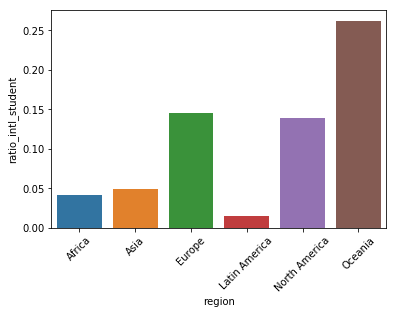

In [34]:
ax = sns.barplot(x="region", y="ratio_intl_student", data=ranking_aggregated_region.reset_index())
plt.xticks(rotation=45)
plt.show(ax)

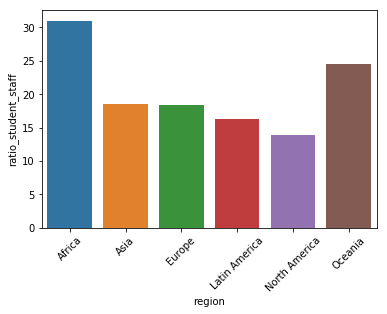

In [33]:
ax = sns.barplot(x="region", y="ratio_student_staff", data=ranking_aggregated_region.reset_index())
plt.xticks(rotation=45)
plt.show(ax)